# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [1]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
import sklearn.metrics as skm
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os

## Generating the data

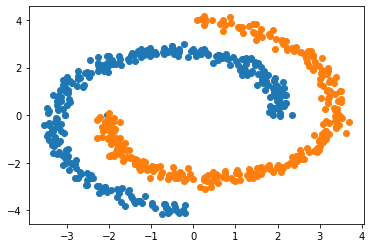

Signature: worst_case_blob(num_samples, delta=5)
Docstring:
Generates a single blob.

:param num_samples: number of samples to create in the blob
:param delta:
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      ~/Desktop/Etude/MVA_S2/Graphs_inML/TP1/graphsexercises/spectral_clustering/generate_data.py
Type:      function


In [4]:
# Example
np.random.seed(5)
for fn in [two_moons]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
worst_case_blob?

## Building similarity graph

In [5]:
def build_similarity_graph(X, var=1.0, eps=0.8, k= 20):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
  
    similarities = np.zeros((n, n))
    
    #me 
    for i in range(n):
        for j in range(i):
            similarities[i, j] = np.exp( - (np.linalg.norm(X[i] - X[j])**2)/(2*var) )
            similarities[j, i] = similarities[i,j] # because symetric
    
    

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        for i in range (n):
            for j in range(i):
                simil_ij = similarities[i, j]
                if simil_ij >= eps:
                    W[i,j] = simil_ij
                    W[j,i] = simil_ij
                    

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        
        # remove self similarity 
        similarities = similarities- np.diag(np.diag(similarities))
        
        for i in range(n):
            NNbors = np.argsort(similarities[i])
            
            for NN in NNbors[-k:][::-1]:
                W[i, NN] = similarities[i, NN]
        W = np.maximum(W, W.T) # to have have undirected graph


    return W


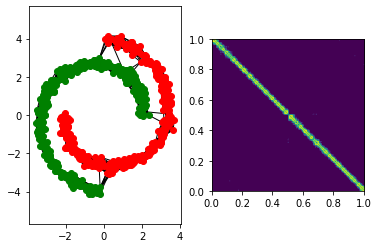

In [6]:
# Example

W = build_similarity_graph(X)
W[0, 599] = 1    # for example, to visualize below
W[10, 500] = 1   # 


plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [77]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    L = np.zeros(W.shape)
    D =  np.diag(W.sum(axis = 1))    
    if laplacian_normalization =='unn':
        L = D - W
    elif laplacian_normalization =='sym':
        invD = np.linalg.inv(D)**(0.5)
        L = invD@L@invD 
    elif laplacian_normalization =='rw':
        L = np.eye(W.shape[0]) - np.linalg.inv(D)@W
    else:
        print('Error')
    return L

## Clustering

In [8]:
import scipy
from sklearn.cluster import KMeans

In [9]:
'''
a  = np.array([[1,0], [1,1]])
eiv, eivec = scipy.linalg.eig(a)
print(eiv.real)
print('')
print(eivec.real)
'''


"\na  = np.array([[1,0], [1,1]])\neiv, eivec = scipy.linalg.eig(a)\nprint(eiv.real)\nprint('')\nprint(eivec.real)\n"

In [10]:
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    eigvals, eigvec = scipy.linalg.eig(L)
    eigvals_r = eigvals.real             # since scipy eigvals are complex numbers 
    ind_sort = np.argsort(eigvals_r) 
    eigvals_sort = eigvals_r[ind_sort]
    
    
    E = np.diag(eigvals_sort)
    U = eigvec[:, ind_sort].real
    
    U =  U[:, chosen_eig_indices]

    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    
    # as we could have several classes, we use Kmeans algo
    Y = np.zeros(L.shape[0])
    kmeans = KMeans(num_classes)
    
    Y = kmeans.fit_predict(U)
    return Y

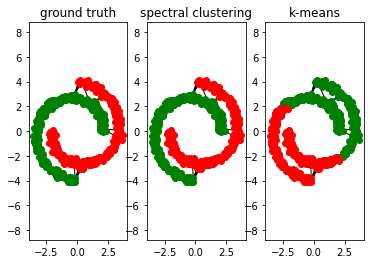

In [11]:
# Example

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1, 2], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [121]:
def parameter_sensitivity():
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    #laplacian_normalization = 'rw'
    laplacian_normalization = 'unn'
    chosen_eig_indices = [1, 2]

    """
    Choose candidate parameters
    """
    parameter_candidate = list(np.arange(1,50, 2))          #[1, 2]  # the number of neighbours for the graph or the epsilon threshold
    #parameter_candidate = list( np.linspace(0.1, 0.99, 20)) 
    parameter_performance = []

    #for eps in parameter_candidate:
    for k in parameter_candidate:
        # Generate data
        X, Y = two_moons(num_samples, 1, 0.02)
        num_classes = len(np.unique(Y))

        W = build_similarity_graph(X, k=k)
        #W = build_similarity_graph(X, eps = eps, k=0)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    plt.title('parameter sensitivity')
    plt.show()

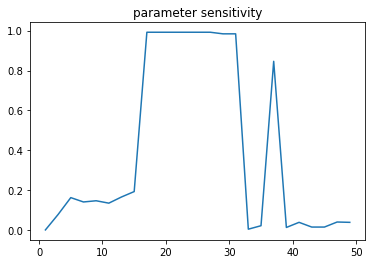

In [122]:
# good k are between 20 -30  and esp (0.2, 0.8) and (0.85, 1) for unn

parameter_sensitivity()

## Image segmentation

In [118]:
def image_segmentation(input_img='four_elements.bmp'):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    var = 1.0
    k = 20
    laplacian_normalization = 'unn'
    chosen_eig_indices = [1, 2, 3,4,5]
    num_classes = 5

    W = build_similarity_graph(Xr, var=var, k=k)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

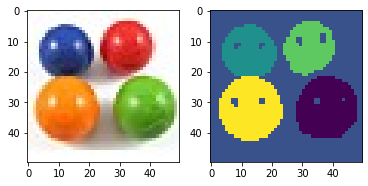

In [119]:
image_segmentation()

# Questions

### Q1: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph. 

It's important to build connected graph because if we have disconnected graph, it's like we have two (or several graphs (not interesting). 
In the knn graph, we have to set k hight begore having connected. In the $\epsilon$ graphs, each cluster is very  dense and very connected. If we had different densities for each cluster , it would result in huge difference between classes.

### Q2: The function `min_span_tree` can be used to choose the value of $\epsilon$ that keeps the graph connected. Using the `worst_case_blob`, can you tell when it is a bad idea to use this approach?

In [120]:
min_span_tree?

Signature: min_span_tree(W)
Docstring:
:param W: (n x n) adjacency matrix representing the graph
:return: T: (n x n) matrix such that T[i,j] = True if the edge (i, j) is in the min spanning tree, and
            T[i, j] = False otherwise
File:      ~/Desktop/Etude/MVA_S2/Graphs_inML/TP1/graphsexercises/spectral_clustering/utils.py
Type:      function


### A2:

In [ ]:
X, Y= worst_case_blob(600, delta=5)

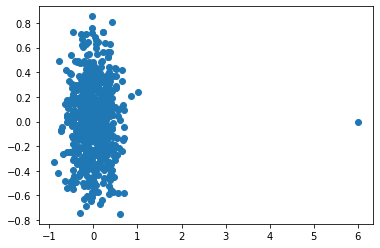

In [194]:
plot_clusters(X, Y)

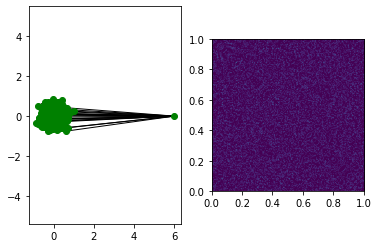

In [203]:
W = build_similarity_graph(X)
min_span = min_span_tree(-W) # the opposite of the simimarity is used  # we could have used directly the euclidienne normalised distance 
eps_max = np.max(W[min_span])

# now we have the maximum epsilon we can compute W and plot
W = build_similarity_graph(X, eps = eps_max)
plot_graph_matrix(X, Y, W)

If we use the min spanning  tree  on the similarities matrix (W), the algorithm will try to connect nodes with weak similarities (hence far nodes) in order to minimize the total sum (It doesn't make sense). Instead of doing this, we can simply use the dissimilarity matrice  (-W for example) and then the algorithm will keep large threshold ($\epsilon$) in order to connect far nodes as possible. However the algorithm may not be robust when trying to connect outliers ( for very large  $\epsilon$) so not effecient anymore  (As in above figure)

### Q3: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

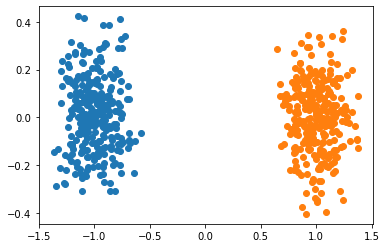

In [227]:
#blobs?
X, Y = blobs(num_samples=600)
plot_clusters(X, Y)

### A3:

In [228]:
def blobs_clustering(W, var = 1.0,  chosen_ind = [1] , number_cl =2):
    
    
    # since we want to construct epsilon connected graph, we will use min_span tree
    # also there is no 
    #he number of class (it's already two here)
    #number_cl = np.unique(Y).shape[0]
   


    # parameters 
    #lapl_norm = 'unn'
    
    #chosen_ind = [1] # since we have connected graph 
    
    # use previous functions 
    L = build_laplacian(W, laplacian_normalization='unn')
    Y_pred = spectral_clustering(L, chosen_eig_indices= chosen_ind, num_classes= number_cl)
    return Y_pred, eps_max

We choose $\epsilon$ such that the graph is connected (span_tree)

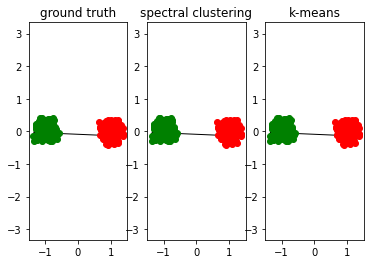

In [240]:
W = build_similarity_graph(X, eps= 0.4485, k = 0) # epsilon graph

#L = build_laplacian(W)
#L = build_laplacian(W, laplacian_normalization= 'unn')
#num_classes = np.unique(Y).shape[0]


# reconstruction 
Y_rec,epss  = blobs_clustering(W)

plot_clustering_result(X, Y, W, Y_rec, KMeans(num_classes).fit_predict(X))

Since we have connected graph, the eigenvalue 0 (of L)  has 1 as multiplicity. The associated eigen vector to 0 is the constant vector.
Here we use unnormalized Laplacian ,so we can use the second eigenvector ($f_2$) for the classification (Thanks to the Rayleigh-Ritz theorem and slode 34 of the course). We could predict the classes using the fact that compoents of $f_2$ are smaller or greater than 0, but  we just use kmeans which is more general.

### Q4: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

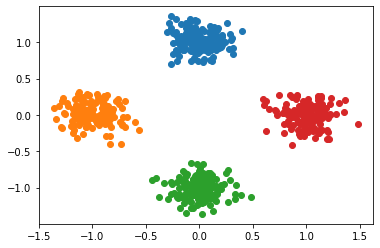

In [486]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.15)
plot_clusters(X, Y)

###  A4:

Since the multiplicity of the eigenvalue 0 is the number of connected components, we want to keep the index of last eigenvalue  before the big gap between two non zero eigenvalues. Hence we use the relative gap. To found this index , we use the relative gap and we have $index = arg \max_{i}\dfrac{\lambda_{i+1}- \lambda_{i} }{\lambda_{i+1} + \lambda_{i} + \mu }$  where $\lambda_{i} \le \lambda_{i+1}, i=1,0.....,n-1$ are eigenvalues. We add $\mu$ to avoid numerical issues such as division by 0 ( $\mu = 1e-10$)

In [17]:
def choice_eigen_inds(eigenvals):
    n = len(eigenvals)
    gaps = np.zeros(n-1) #
    
    
    
    mu = 1e-10# precision 
    # we check if there 0 
    if np.where(np.array(eigenvals)>mu,1,0).sum()>0:
        ind0s = np.argwhere(np.array(eigenvals)> mu)[0][0] # because the result is 2d array
        
    else:
        ind0s = 0
    
    for i in range(ind0s, n-1) :
        gaps[i] = eigenvals[i+1]-eigenvals[i+1]/(eigenvals[i+1]+ eigenvals[i] + mu)
    
    index = np.argmax(gaps) # the index of the huge gap
    
    return  np.arange(index+1)
    
    # now me the index (after which we have the relative big gap)

In [15]:
def spectral_clustering_auto(L, chosen_eig_indices= None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    eigvals, eigvec = scipy.linalg.eig(L)
    eigvals_r = eigvals.real             # since scipy eigvals are complex numbers 
    ind_sort = np.argsort(eigvals_r) 
    eigvals_sort = eigvals_r[ind_sort]
    eigvals_sort =  eigvals_sort[:20] # we reduce the number of candidates eigen vecters
    chosen_eig_indices = choice_eigen_inds(eigvals_sort)
    
    E = np.diag(eigvals_sort)
    U = eigvec[:, ind_sort].real
    
    U =  U[:, chosen_eig_indices[:num_classes]]

    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    
    # as we could have several classes, we use Kmeans algo
    Y = np.zeros(L.shape[0])
    kmeans = KMeans(num_classes)
    
    Y = kmeans.fit_predict(U)
    return Y

In [560]:
eigvals,_ =  scipy.linalg.eig(L)
eigvals_r = eigvals.real             # since scipy eigvals are complex numbers 
ind_sort = np.argsort(eigvals_r) 
eigvals_sort = eigvals_r[ind_sort]
eigvals_sort =   eigvals_sort[:10]
chosen_eig_indices = choice_eigen_inds(eigvals_sort)

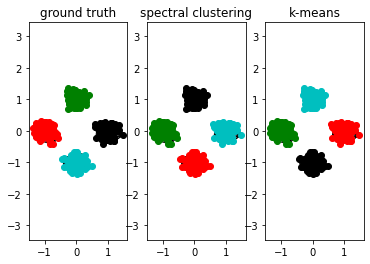

In [554]:
W = build_similarity_graph(X, k = 20, eps = 0.0 ) # knn graph
L = build_laplacian(W, laplacian_normalization= 'unn' )



num_classes = np.unique(Y).shape[0]
Y_rec = spectral_clustering_auto(L, chosen_eig_indices=None, num_classes= num_classes)
plot_clustering_result(X, Y, W, Y_rec, KMeans(num_classes).fit_predict(X))

#### Now we increase the the variance of blobs 

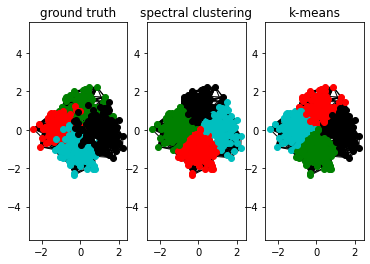

In [557]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.5)
#plot_clusters(X, Y)
W = build_similarity_graph(X, k = 20, eps = 0.0 ) # knn graph
L = build_laplacian(W, laplacian_normalization= 'unn' )

num_classes = np.unique(Y).shape[0]
Y_rec = spectral_clustering_auto(L, chosen_eig_indices=None, num_classes= num_classes)
plot_clustering_result(X, Y, W, Y_rec, KMeans(num_classes).fit_predict(X))

When we inscrease the variance of the blobs are not well separated (even in the ground truth), and our function hardly found good $index$

### Q5: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

### A5:
For two classes, one can use tresholding on the fact that second eigenvector's component  is postive or negative (cluster assignment). In general (for $k$ classes clustering).
It is preferable to make kmeans on the matrix of $k$ eigenvectors corresponding to the k non-zero eigenvalues. And this is what we do in our implementations.

### Q6: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

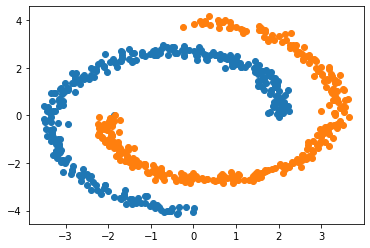

In [578]:
#two_moons?
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

### A6:

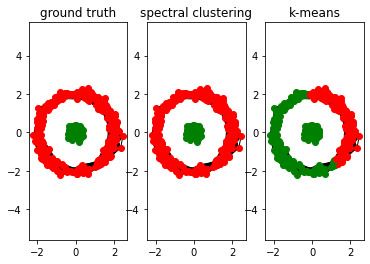

In [45]:

#plot_clusters(X, Y)
W = build_similarity_graph(X, k = 0, eps = 0.7 ) # eps graph
L = build_laplacian(W, laplacian_normalization= 'unn' )

num_classes = np.unique(Y).shape[0]
Y_rec = spectral_clustering_auto(L, chosen_eig_indices= None, num_classes=2)
#Y_rec = spectral_clustering_auto(L, chosen_eig_indices=None, num_classes= num_classes)
plot_clustering_result(X, Y, W, Y_rec, KMeans(num_classes).fit_predict(X))

The metric used by kmeans (Euclidean) to group classes is not very well adapted to data of this form(moon).
Spectral clustering uses the notion of similarity between the nodes of the graph and projects the data in a clean space (spectral decomposition) where they could be easily separable with kmeans. 

### Q7: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

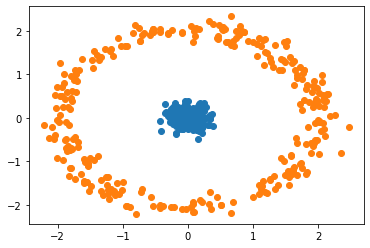

Signature: point_and_circle(num_samples, radius=2.0, sigma=0.15)
Docstring:
Creates point and circle

:param num_samples: number of samples to create in the dataset
:param sigma:       variance
:param radius:      radius of the circle
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment in {0, ..., c-1}
File:      ~/Desktop/Etude/MVA_S2/Graphs_inML/TP1/graphsexercises/spectral_clustering/generate_data.py
Type:      function


In [79]:
point_and_circle?
np.random.seed(5)
X, Y = point_and_circle(num_samples=600, sigma = 0.15)
plot_clusters(X, Y)

### A7

With the unnormalized Laplacian

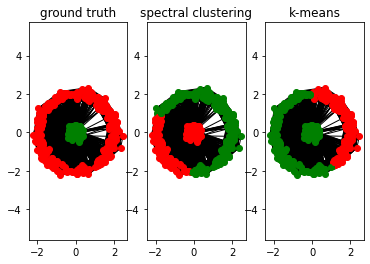

In [85]:

W = build_similarity_graph(X, k = 90, eps = 0.0) # eps graph
L_unn = build_laplacian(W, laplacian_normalization= 'unn' )

num_classes = np.unique(Y).shape[0]


Y_rec_unn = spectral_clustering(L_unn, chosen_eig_indices= [1], num_classes= num_classes)
plot_clustering_result(X, Y, W, Y_rec_unn , KMeans(num_classes).fit_predict(X) )

With random walk Laplacian

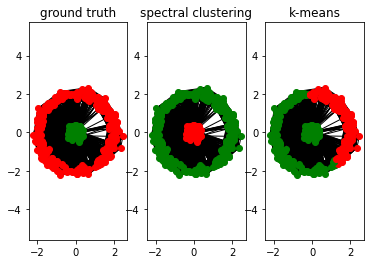

In [87]:
L_rw = build_laplacian(W, laplacian_normalization= 'rw' )
Y_rec_rw = spectral_clustering(L_rw, chosen_eig_indices= [1], num_classes= num_classes)
plot_clustering_result(X, Y, W, Y_rec_rw, KMeans(num_classes).fit_predict(X) )

We built knn graph and for k small, we see that we have a good classification for the random walk and the normal Laplacian (unnormalized) and the random-walk.
By increasing the k (to 90) we could  see that the classification remains good with the random walk, but not with the normal Laplacian.

We can explain this the by RatioCut and, NCut in which we respectively used unnormalized Laplacian and the random walk regularization.
In RatioCut we want to maximize the number of nodes in clusters, but this number is not necessarely related to within-cluster similarity. In NCut, we want to maximize the volume of the clusters, which depends on the weights of the edges. 

### Q8: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

### A8:

We use 600 samples of two_moons, and contruct similarity graph .
He used different 20 values of $\epsilon \in (0.1, 0.99)$, after $k = 1,3,5,....,49$. we noticed the score becomes low , or hight depending or these values.
For instance in our example  good k are between 20 -30  and  $\epsilon$ (0.2, 0.8) and (0.85, 1) for unnormalized Laplacian.

### Q9: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

One solution is to use modularity which measures the difference between how well vertices are assigned into clusters. See on wikipedia (https://en.wikipedia.org/wiki/Modularity_(networks). 

### Q10: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

One idea would be to  reduce the size of image (and then reduce the nodes) and see if there is no significant change in the expected clustering results.

Another should be to quantisize (compress) the graph.